<a href="https://colab.research.google.com/github/nijinpaul/Assignments/blob/main/ASSIGNMENT_RANDOM_FOREST(_COMPANY_DATA_DATASET)Rev0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement:
### A cloth manufacturing company is interested to know about the segment or attributes causes high sale. 
### Approach - A Random Forest can be built with target variable Sales (we will first convert it in categorical variable) & all other variable will be independent in the analysis.  

In [4]:
import numpy as np
import pandas as pd
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier

In [5]:
# import DATA
df = pd.read_csv('/content/Company_Data.csv')
df

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...
395,12.57,138,108,17,203,128,Good,33,14,Yes,Yes
396,6.14,139,23,3,37,120,Medium,55,11,No,Yes
397,7.41,162,26,12,368,159,Medium,40,18,Yes,Yes
398,5.94,100,79,7,284,95,Bad,50,12,Yes,Yes


In [6]:
df.shape

(400, 11)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Sales        400 non-null    float64
 1   CompPrice    400 non-null    int64  
 2   Income       400 non-null    int64  
 3   Advertising  400 non-null    int64  
 4   Population   400 non-null    int64  
 5   Price        400 non-null    int64  
 6   ShelveLoc    400 non-null    object 
 7   Age          400 non-null    int64  
 8   Education    400 non-null    int64  
 9   Urban        400 non-null    object 
 10  US           400 non-null    object 
dtypes: float64(1), int64(7), object(3)
memory usage: 34.5+ KB


In [8]:
df['Sales'].describe()

count    400.000000
mean       7.496325
std        2.824115
min        0.000000
25%        5.390000
50%        7.490000
75%        9.320000
max       16.270000
Name: Sales, dtype: float64

Binning the Sales colum to create three distinct categories: low, medium and high sales.

In [9]:
bins = np.linspace(min(df['Sales']), max(df['Sales']), 4)
bins

array([ 0.        ,  5.42333333, 10.84666667, 16.27      ])

In [10]:
label_names = ['Low', 'Medium', 'High']
df['Sales_bin'] = pd.cut(df['Sales'], bins, labels=label_names, include_lowest=True )
df[['Sales','Sales_bin']].head()

,Sales,Sales_bin
0,9.50,Medium
1,11.22,High
2,10.06,Medium
3,7.40,Medium
4,4.15,Low


In [11]:
# Dropping the sales column as only binned column is necessary
df.drop('Sales',axis=1,inplace=True)
df.head()

,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,Sales_bin
0,138,73,11,276,120,Bad,42,17,Yes,Yes,Medium
1,111,48,16,260,83,Good,65,10,Yes,Yes,High
2,113,35,10,269,80,Medium,59,12,Yes,Yes,Medium
3,117,100,4,466,97,Medium,55,14,Yes,Yes,Medium
4,141,64,3,340,128,Bad,38,13,Yes,No,Low


In [12]:
# checking the data distribution in output variable
df['Sales_bin'].value_counts()

Medium    247
Low       102
High       51
Name: Sales_bin, dtype: int64

In [13]:
l=(df['Sales_bin']=='Low').sum()/len(df)*100
m=(df['Sales_bin']=='Medium').sum()/len(df)*100
h=(df['Sales_bin']=='High').sum()/len(df)*100

print("Percent of data labelled as Low:",np.round(l,2))
print("Percent of data labelled as Medium:",np.round(m,2))
print("Percent of data labelled as High:",np.round(h,2))

Percent of data labelled as Low: 25.5
Percent of data labelled as Medium: 61.75
Percent of data labelled as High: 12.75


60 percent of data is labelled as medium whereas rest 40 percent comprises of other labels.So this dataset has slight imbalance with bias towards Medium label.

In [14]:
# Label Encoding Categorical Columns

from sklearn import preprocessing

cols=['ShelveLoc','Urban','US','Sales_bin']  

le=preprocessing.LabelEncoder()
for col in cols:
    
    df[col]=le.fit_transform(df[col])
    print(le.classes_)

['Bad' 'Good' 'Medium']
['No' 'Yes']
['No' 'Yes']
['High' 'Low' 'Medium']


In [15]:
# checking the data distribution in output variable
df['Sales_bin'].value_counts()

2    247
1    102
0     51
Name: Sales_bin, dtype: int64

In [16]:
df.head()

,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,Sales_bin
0,138,73,11,276,120,0,42,17,1,1,2
1,111,48,16,260,83,1,65,10,1,1,0
2,113,35,10,269,80,2,59,12,1,1,2
3,117,100,4,466,97,2,55,14,1,1,2
4,141,64,3,340,128,0,38,13,1,0,1


### Building Random Forest for classification and evaluating its overall performance using cross validation score.

In [17]:
arr=df.values
x=arr[:,:-1]
y=arr[:,-1]

In [18]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=45)

In [19]:
# define the model
# Using 100 trees and max_features=4
rfc1 = RandomForestClassifier(n_estimators=100,max_features=4)

In [20]:
# Evaluate the base model(without hypertuning)

from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=10,shuffle=True)
result = cross_val_score(rfc1, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

print("Accuracy is:",np.mean(result))

Accuracy is: 0.6714285714285715


In [21]:
# Iterating over a range of folds in StratifiedKFold

from sklearn.model_selection import GridSearchCV

mean_accuracy=[]
n_folds=[]

for i in range(2,15):
    cv2=StratifiedKFold(n_splits=i,shuffle=True,random_state=20)
    result = cross_val_score(rfc1, x_train, y_train, scoring='accuracy', cv=cv2, error_score='raise')
    avg=np.mean(result)
    mean_accuracy.append(avg)
    n_folds.append(i)
    


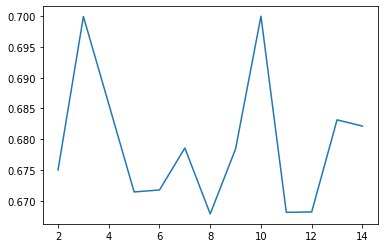

In [22]:
## Visualizing the scores generated for each number of folds

import seaborn as sns
sns.lineplot(x=n_folds,y=mean_accuracy)

## Fitting the model and finding the important features

In [23]:
rfc1.fit(x_train,y_train)
rfc1.feature_importances_

array([0.12184902, 0.11069029, 0.0854919 , 0.11077555, 0.1767428 ,
       0.14285959, 0.14513694, 0.06755804, 0.01803469, 0.02086118])

In [24]:
cols=['CompPrice', 'Income', 'Advertising', 'Population', 'Price','ShelveLoc', 'Age', 'Education', 'Urban', 'US']
feature_imp=pd.Series(rfc1.feature_importances_,index=cols).sort_values(ascending=False)
feature_imp

Price          0.176743
Age            0.145137
ShelveLoc      0.142860
CompPrice      0.121849
Population     0.110776
Income         0.110690
Advertising    0.085492
Education      0.067558
US             0.020861
Urban          0.018035
dtype: float64

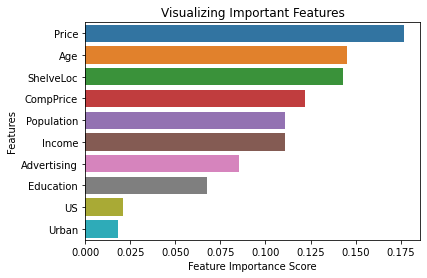

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()


The four most important features/attributes for predicting sales of this company are:Price,ShelveLoc,Age and CompPrice

In [26]:
# Prediction and accuracy score calculation
pred1 = rfc1.predict(x_test)

from sklearn.metrics import classification_report
target_names=['0-High', '1-Low', '2-Medium']
print(classification_report(y_test, pred1,target_names=target_names))

              precision    recall  f1-score   support

      0-High       0.80      0.27      0.40        15
       1-Low       0.74      0.54      0.62        26
    2-Medium       0.76      0.92      0.83        79

    accuracy                           0.76       120
   macro avg       0.77      0.58      0.62       120
weighted avg       0.76      0.76      0.73       120



In [27]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix
conf_matrix1=confusion_matrix(y_test, pred1)
conf_matrix1

array([[ 4,  0, 11],
       [ 0, 14, 12],
       [ 1,  5, 73]])

## Hyper Tuning Random Forest 

In [28]:
## Getting the features with which the base model was fitted
rfc1.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 4,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

## 1. Using RandomizedSearchCV

In [29]:
from sklearn.model_selection import RandomizedSearchCV

cv3 = StratifiedKFold(n_splits=3,shuffle=True)

random_grid = {'n_estimators': [x for x in range(50,200,10)],
               'max_features': [x for x in range(2,9)],
               'max_depth': [x for x in range(2,15)],
               'min_samples_split':[x for x in range(5,50,5)],
               'min_samples_leaf': [x for x in range(2,10)]}
                                    
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
random_cv = RandomizedSearchCV(estimator = rfc1, param_distributions = random_grid, n_iter = 100,
                               cv = cv3,scoring='accuracy', verbose=2, random_state=42, n_jobs = -1)  
                                    
# fitting the model for random grid search 
random_cv.fit(x_train, y_train) 

                              

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
                   estimator=RandomForestClassifier(max_features=4), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14],
                                        'max_features': [2, 3, 4, 5, 6, 7, 8],
                                        'min_samples_leaf': [2, 3, 4, 5, 6, 7,
                                                             8, 9],
                                        'min_samples_split': [5, 10, 15, 20, 25,
                                                              30, 35, 40, 45],
                                        'n_estimators': [50, 60, 70, 80, 90,
                                                         100, 110, 120, 130,
                                                         140, 150, 160, 170,
                                   

In [30]:
# Finding best parameter after tuning 
print("Best score for RandomSearchCV is:",random_cv.best_score_)
print("Optimal parameters for RandomSearchCV is:",random_cv.best_params_)       

Best score for RandomSearchCV is: 0.6678486997635934
Optimal parameters for RandomSearchCV is: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 6, 'max_depth': 10}


In [31]:
## storing the best parameters in a variable
## fitting the model with best parameters

d= random_cv.best_params_

rfc2= RandomForestClassifier(n_estimators=d['n_estimators'], min_samples_split=d['min_samples_split'],
                             min_samples_leaf=d['min_samples_leaf'],max_features=d['max_features'],
                             max_depth=d['max_depth'])

rfc2.fit(x_train,y_train)

RandomForestClassifier(max_depth=10, max_features=6, min_samples_leaf=2,
                       min_samples_split=10)

In [32]:
# Prediction and accuracy score calculation

pred2 = rfc2.predict(x_test)
target_names=['0-High', '1-Low', '2-Medium']
print(classification_report(y_test, pred2,target_names=target_names,zero_division=1))

              precision    recall  f1-score   support

      0-High       0.86      0.40      0.55        15
       1-Low       0.76      0.62      0.68        26
    2-Medium       0.79      0.92      0.85        79

    accuracy                           0.79       120
   macro avg       0.80      0.65      0.69       120
weighted avg       0.79      0.79      0.78       120



In [33]:
conf_matrix2=confusion_matrix(y_test,pred2)
conf_matrix2

array([[ 6,  0,  9],
       [ 0, 16, 10],
       [ 1,  5, 73]])

## Plotting Confusion Matrices

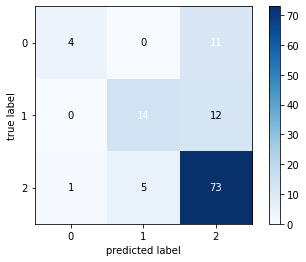

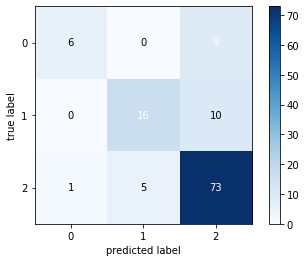

<Figure size 432x288 with 0 Axes>

In [40]:
from mlxtend.plotting import plot_confusion_matrix

#fig, axis= plt.subplots(1,2, figsize=(15,10),dpi=150)


fig, ax = plot_confusion_matrix(conf_mat=conf_matrix1,colorbar=True,show_absolute=True,show_normed=False)#, label=class_names)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix2,colorbar=True,show_absolute=True,show_normed=False)#, label=class_names)

plt.show()





plt.subplots_adjust(wspace=0.5)
plt.show()

+ The above models work better in predicting medium sales(label=2) compared to low(label=1) and high sales(label =0).


+ Hypertuning the base model has increased the accuracy of predicting label 2(medium sales) only.


+ As the dataset is biased towards medium label (60 percent of dataset has labels as Medium),the model has trained itself to predict this label far more accurately compared to other two labels.